In [3]:
import json

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets


class EmotionCNN(nn.Module):
    def __init__(self, num_classes):
        super(EmotionCNN, self).__init__()

        # First Convolutional Block
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )

        # Second Convolutional Block
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )

        # Third Convolutional Block
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )

        # Fourth Convolutional Block
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 3 * 3, 512),  # Adjust based on input size
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.classifier(x)
        return x


class EmotionRecognitionTrainer:
    def __init__(self, img_height=48, img_width=48, batch_size=64, device=None):
        self.scheduler = None
        self.criterion = None
        self.optimizer = None
        self.img_height = img_height
        self.img_width = img_width
        self.batch_size = batch_size
        default_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.device = device if device else default_device

        self.num_classes = None
        self.train_loader = None
        self.val_loader = None
        self.test_loader = None
        self.model = None
        self.history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
        self.class_labels = None

        print(f"Using device: {self.device}")

    def setup_data_loaders(self, train_dir, test_dir, validation_split=0.2):
        """Set up data loaders with augmentation"""
        # Data transformations
        train_transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize((self.img_height, self.img_width)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(20),
            transforms.RandomResizedCrop((self.img_height, self.img_width), scale=(0.8, 1.0)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

        test_transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize((self.img_height, self.img_width)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

        # Load datasets
        full_train_dataset = datasets.ImageFolder(
            root=train_dir,
            transform=train_transform
        )

        test_dataset = datasets.ImageFolder(
            root=test_dir,
            transform=test_transform
        )

        # Split train into train and validation
        train_size = int((1 - validation_split) * len(full_train_dataset))
        val_size = len(full_train_dataset) - train_size

        train_dataset, val_dataset = random_split(
            full_train_dataset, [train_size, val_size]
        )

        # Override transforms for validation to remove augmentation
        val_dataset.dataset = datasets.ImageFolder(
            root=train_dir,
            transform=test_transform
        )

        # Create data loaders
        self.train_loader = DataLoader(
            train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=2
        )

        self.val_loader = DataLoader(
            val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=2
        )

        self.test_loader = DataLoader(
            test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=2
        )

        self.class_labels = full_train_dataset.classes
        self.num_classes = len(self.class_labels)

        print(f"Class labels: {self.class_labels}")
        print(f"Number of classes: {self.num_classes}")
        print(f"Training samples: {len(train_dataset)}")
        print(f"Validation samples: {len(val_dataset)}")
        print(f"Test samples: {len(test_dataset)}")

        return self.train_loader, self.val_loader, self.test_loader

    def build_model(self):
        """Build CNN model for emotion recognition"""
        self.model = EmotionCNN(self.num_classes).to(self.device)
        return self.model

    def compile_model(self, learning_rate=0.001, weight_decay=1e-5):
        """Compile the model (setup optimizer and loss) with weight decay"""
        self.optimizer = optim.Adam(
            self.model.parameters(),
            lr=learning_rate,
            weight_decay=weight_decay  # Added weight_decay parameter
        )
        self.criterion = nn.CrossEntropyLoss()
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=0.2,
                                           patience=10, min_lr=1e-7)

        print("Model compiled successfully!")
        print(f"Optimizer: Adam(lr={learning_rate}, weight_decay={weight_decay})")
        print(f"Model architecture:\n{self.model}")

    def train_epoch(self):
        """Train for one epoch"""
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (data, target) in enumerate(self.train_loader):
            data, target = data.to(self.device), target.to(self.device)

            self.optimizer.zero_grad()
            output = self.model(data)
            loss = self.criterion(output, target)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

        epoch_loss = running_loss / len(self.train_loader)
        epoch_acc = 100. * correct / total

        return epoch_loss, epoch_acc

    def validate_epoch(self):
        """Validate for one epoch"""
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for data, target in self.val_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                loss = self.criterion(output, target)

                running_loss += loss.item()
                _, predicted = output.max(1)
                total += target.size(0)
                correct += predicted.eq(target).sum().item()

        epoch_loss = running_loss / len(self.val_loader)
        epoch_acc = 100. * correct / total

        return epoch_loss, epoch_acc

    def train(self, epochs=100, patience=15):
        """Train the model with early stopping"""
        best_val_acc = 0.0
        patience_counter = 0
        best_model_state = None

        for epoch in range(epochs):
            # Train
            train_loss, train_acc = self.train_epoch()

            # Validate
            val_loss, val_acc = self.validate_epoch()

            # Update learning rate
            self.scheduler.step(val_loss)

            # Store history
            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)

            print(f'Epoch {epoch + 1}/{epochs}:')
            print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
            print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

            # Save the best model
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
                best_model_state = self.model.state_dict().copy()
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'val_acc': val_acc,
                    'val_loss': val_loss,
                }, 'best_emotion_model.pth')
                print(f'  → New best model saved! Val Acc: {val_acc:.2f}%')
            else:
                patience_counter += 1

            # Early stopping
            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch + 1}')
                break

        # Load the best model
        if best_model_state is not None:
            self.model.load_state_dict(best_model_state)

        return self.history

    def evaluate_model(self):
        """Evaluate the model on a test set"""
        # Load the best model
        checkpoint = torch.load('best_emotion_model.pth')
        self.model.load_state_dict(checkpoint['model_state_dict'])

        self.model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        all_predictions = []
        all_targets = []

        with torch.no_grad():
            for data, target in self.test_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                loss = self.criterion(output, target)

                test_loss += loss.item()
                _, predicted = output.max(1)
                total += target.size(0)
                correct += predicted.eq(target).sum().item()

                all_predictions.extend(predicted.cpu().numpy())
                all_targets.extend(target.cpu().numpy())

        test_accuracy = 100. * correct / total
        test_loss = test_loss / len(self.test_loader)

        print(f"\nTest Accuracy: {test_accuracy:.2f}%")
        print(f"Test Loss: {test_loss:.4f}")

        # Classification report
        print("\nClassification Report:")
        print(classification_report(all_targets, all_predictions,
                                    target_names=self.class_labels))

        return test_accuracy, test_loss

    def plot_training_history(self):
        """Plot training history"""
        if not self.history['train_loss']:
            print("No training history available!")
            return

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Accuracy plot
        ax1.plot(self.history['train_acc'], label='Training Accuracy')
        ax1.plot(self.history['val_acc'], label='Validation Accuracy')
        ax1.set_title('Model Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy (%)')
        ax1.legend()
        ax1.grid(True)

        # Loss plot
        ax2.plot(self.history['train_loss'], label='Training Loss')
        ax2.plot(self.history['val_loss'], label='Validation Loss')
        ax2.set_title('Model Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()
        plt.show()

    def save_class_labels(self, file_path='class_labels.json'):
        """Save class labels for inference"""
        with open(file_path, 'w') as f:
            json.dump(self.class_labels, f)
        print(f"Class labels saved to {file_path}")

    def predict(self, image_tensor):
        """Make a prediction on a single image"""
        self.model.eval()
        with torch.no_grad():
            image_tensor = image_tensor.unsqueeze(0).to(self.device)
            output = self.model(image_tensor)
            probabilities = torch.softmax(output, dim=1)
            confidence, predicted = torch.max(probabilities, 1)

        return predicted.item(), confidence.item()

In [4]:
# Initialize trainer
trainer = EmotionRecognitionTrainer(img_height=48, img_width=48, batch_size=64)

# Setup data
train_dir = 'D:/Portfolio/DL Project/dataset/train'
test_dir = 'D:/Portfolio/DL Project/dataset/test'
trainer.setup_data_loaders(train_dir, test_dir)

# Build and compile model
trainer.build_model()

Using device: cuda
Class labels: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Number of classes: 7
Training samples: 22967
Validation samples: 5742
Test samples: 7178


EmotionCNN(
  (conv_block1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, s

In [5]:
trainer.compile_model(learning_rate=0.001)

Model compiled successfully!
Optimizer: Adam(lr=0.001, weight_decay=1e-05)
Model architecture:
EmotionCNN(
  (conv_block1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [6]:
history = trainer.train(epochs=100, patience=15)

Epoch 1/100:
  Train Loss: 1.8615, Train Acc: 25.72%
  Val Loss: 1.5844, Val Acc: 38.61%
  → New best model saved! Val Acc: 38.61%
Epoch 2/100:
  Train Loss: 1.5798, Train Acc: 38.26%
  Val Loss: 1.4095, Val Acc: 46.06%
  → New best model saved! Val Acc: 46.06%
Epoch 3/100:
  Train Loss: 1.4483, Train Acc: 43.88%
  Val Loss: 1.3220, Val Acc: 48.35%
  → New best model saved! Val Acc: 48.35%
Epoch 4/100:
  Train Loss: 1.3721, Train Acc: 47.19%
  Val Loss: 1.2392, Val Acc: 51.92%
  → New best model saved! Val Acc: 51.92%
Epoch 5/100:
  Train Loss: 1.3276, Train Acc: 49.20%
  Val Loss: 1.2259, Val Acc: 52.39%
  → New best model saved! Val Acc: 52.39%
Epoch 6/100:
  Train Loss: 1.2862, Train Acc: 50.96%
  Val Loss: 1.1707, Val Acc: 55.21%
  → New best model saved! Val Acc: 55.21%
Epoch 7/100:
  Train Loss: 1.2760, Train Acc: 51.24%
  Val Loss: 1.1516, Val Acc: 55.26%
  → New best model saved! Val Acc: 55.26%
Epoch 8/100:
  Train Loss: 1.2393, Train Acc: 53.37%
  Val Loss: 1.1288, Val Acc: 5

In [7]:
trainer.evaluate_model()


Test Accuracy: 67.23%
Test Loss: 0.9198

Classification Report:
              precision    recall  f1-score   support

       angry       0.59      0.60      0.59       958
     disgust       0.70      0.51      0.59       111
        fear       0.56      0.44      0.49      1024
       happy       0.87      0.88      0.88      1774
     neutral       0.57      0.70      0.63      1233
         sad       0.57      0.53      0.55      1247
    surprise       0.77      0.78      0.77       831

    accuracy                           0.67      7178
   macro avg       0.66      0.64      0.64      7178
weighted avg       0.67      0.67      0.67      7178



(67.23321259403734, 0.9197621335629869)

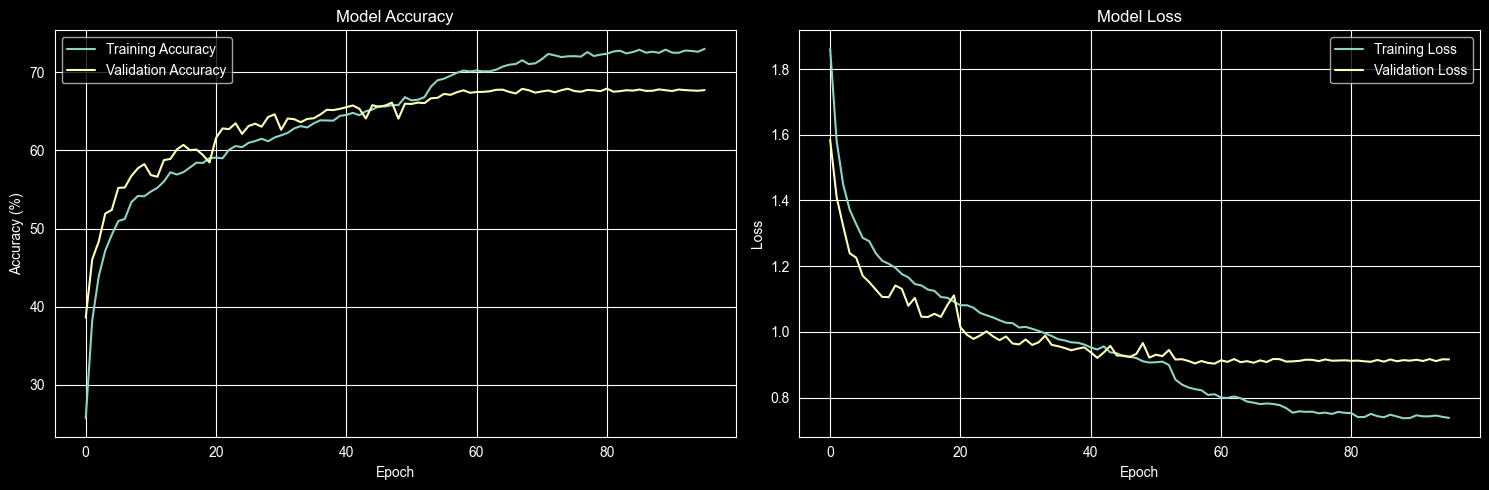

In [8]:
trainer.plot_training_history()

In [9]:
trainer.save_class_labels()

Class labels saved to class_labels.json
